In [1]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, time
from collections import Counter
import statsmodels.formula.api as smf

%matplotlib inline
mpl.rcParams['figure.dpi']= 300

sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reproducibility 
seed = 42
numpy_rng = np.random.RandomState(42)

In [3]:
# Loading formatted data
data_folder = '../../data/generated/'
actor_df = pd.read_pickle(data_folder + 'actor_df.pkl')
appears_in_df = pd.read_pickle(data_folder + 'appears_in_df.pkl')
belongs_to_df = pd.read_pickle(data_folder + 'belongs_to_df.pkl')
character_df = pd.read_pickle(data_folder + 'character_df.pkl')
comes_from_df = pd.read_pickle(data_folder + 'comes_from_df.pkl')
country_df = pd.read_pickle(data_folder + 'country_df.pkl')
genre_df = pd.read_pickle(data_folder + 'genre_df.pkl')
is_of_type_df = pd.read_pickle(data_folder + 'is_of_type_df.pkl')
language_df = pd.read_pickle(data_folder + 'language_df.pkl')
movie_df = pd.read_pickle(data_folder + 'movie_df.pkl')
movie_metadata = pd.read_pickle(data_folder + 'movie_metadata.pkl')
play_df = pd.read_pickle(data_folder + 'play_df.pkl')
spoken_languages_df = pd.read_pickle(data_folder + 'spoken_languages_df.pkl')
wikipedia_imdb_mapping_df = pd.read_pickle(data_folder + 'wikipedia_imdb_mapping_df.pkl')

In [4]:
# Release year formatting
movie_df = movie_df.dropna(subset=['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df = movie_df[(movie_df['release_year'] >= 1920) & (movie_df['release_year'] <= 2012)].sort_values(by='release_year')
print(f"Dataset contains {len(movie_df)} movies from {movie_df['release_year'].min()} to {movie_df['release_year'].max()}")

# Group by decade
movie_df['release_decade'] = (movie_df.release_year//10)*10
movie_df.head()

Dataset contains 75900 movies from 1920 to 2012


,name,release_date,revenue,runtime,freebase_id,plot,release_year,release_decade
movie_id,,,,,,,,
15327624,The Star of Damascus,1920-09-03,NaN,NaN,/m/03m53b8,NaN,1920,1920
35871682,A Woman Who Understood,1920-03-14,NaN,NaN,/m/0jwy13x,NaN,1920,1920
15119049,The Man with the Punch,1920-12-18,NaN,19.0,/m/03hj2jp,NaN,1920,1920
13113803,Face à l’Océan,1920-11-05,NaN,NaN,/m/02z71x_,NaN,1920,1920
22643321,Hidden Lives,1920-02-20,NaN,NaN,/m/05zrzxj,Arundel is an ambitious professor who is worki...,1920,1920


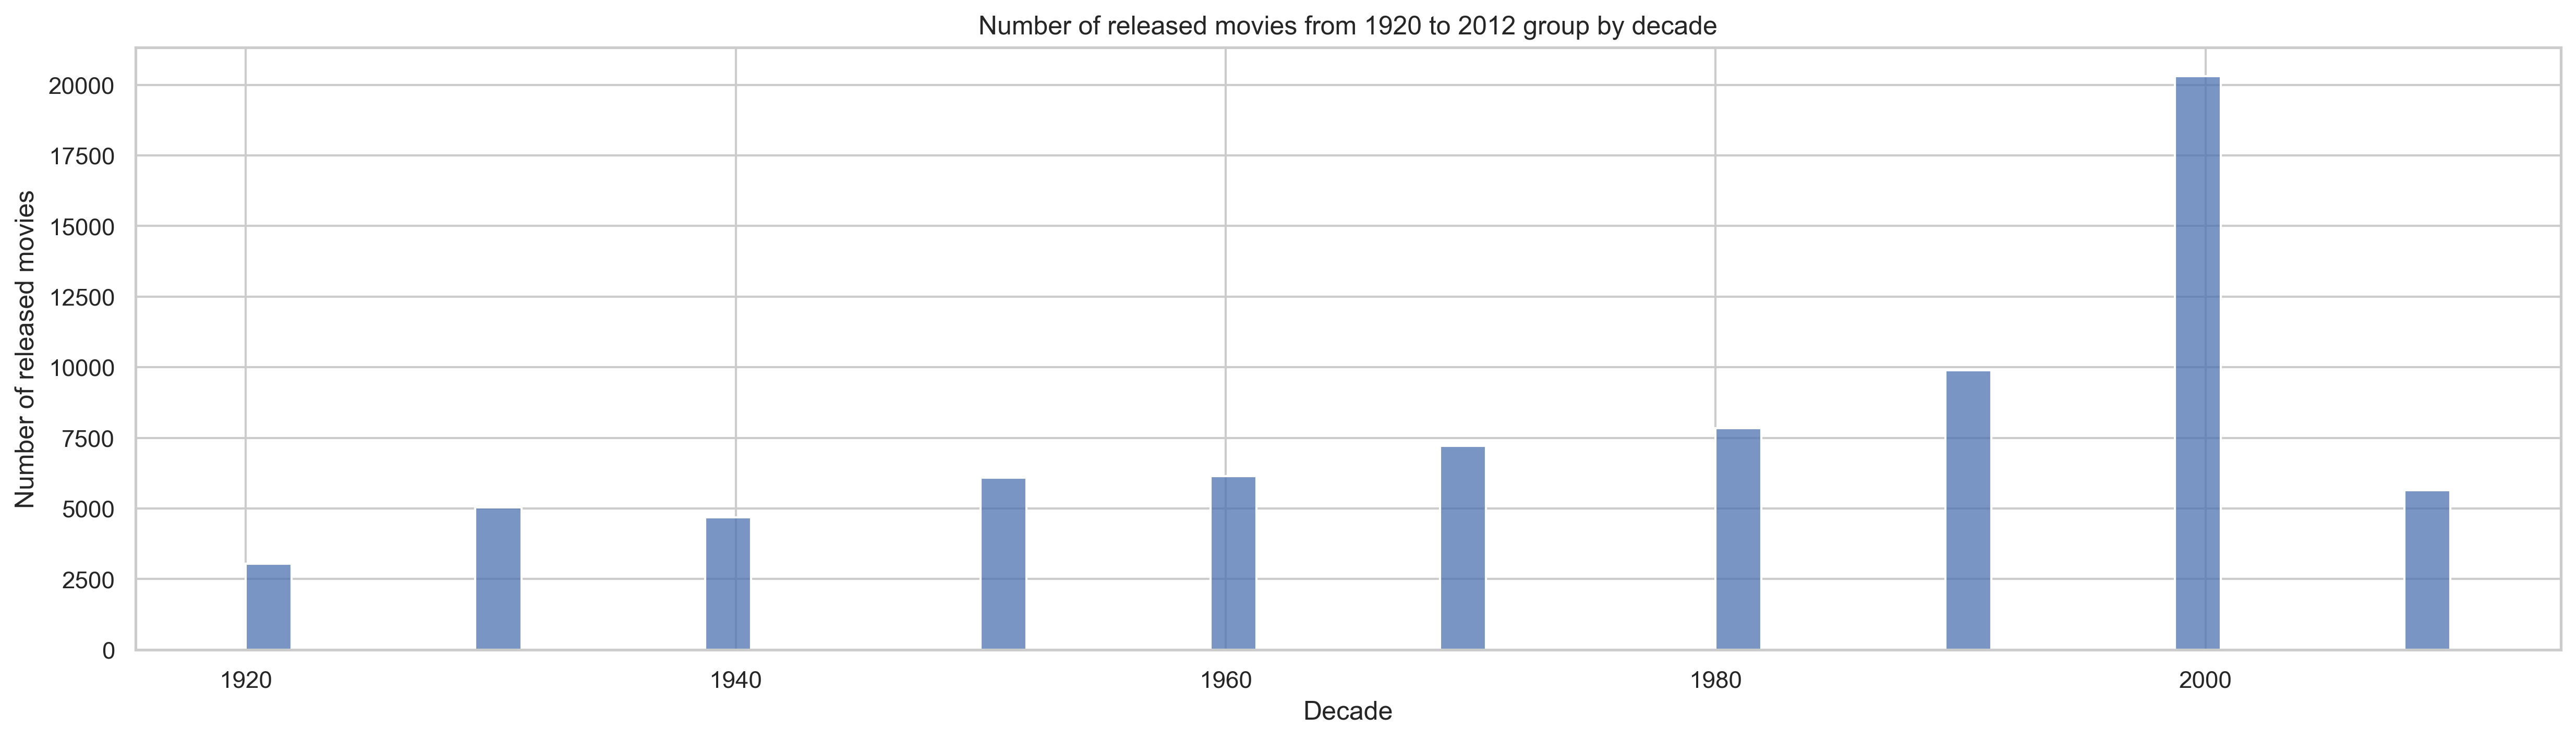

In [5]:
plt.figure(figsize=(20,5))
sns.histplot(data=movie_df, x='release_decade', legend='brief')
plt.title("Number of released movies from 1920 to 2012 group by decade")
plt.xlabel("Decade")
plt.ylabel("Number of released movies")
plt.show()

### Revenue

In [6]:
movie_revenue = movie_df.dropna(subset=['revenue'])

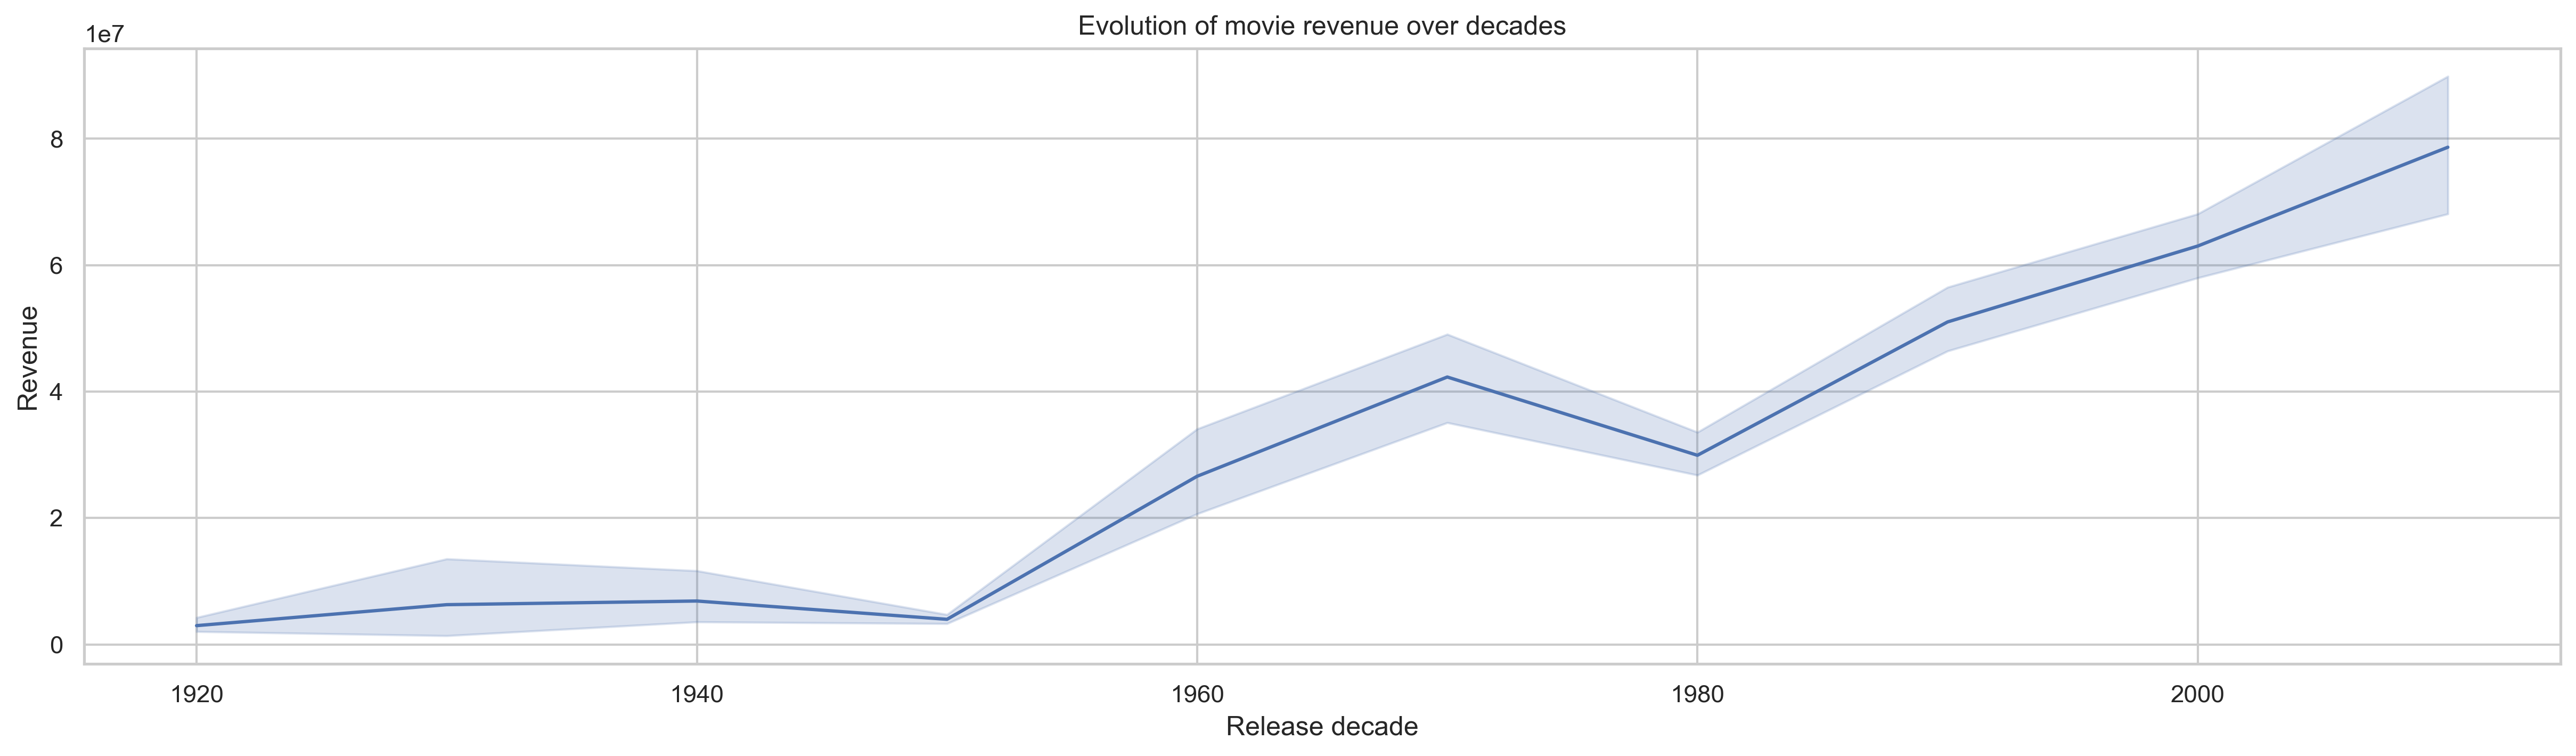

In [7]:
plt.figure(figsize=(20,5))
sns.lineplot(data=movie_revenue, x='release_decade', y='revenue', legend='brief', ci=95)
plt.title('Evolution of movie revenue over decades')
plt.xlabel("Release decade")
plt.ylabel("Revenue")
plt.show()

### Runtime

In [8]:
movie_runtime = movie_df.dropna(subset=['runtime'])
movie_runtime = movie_runtime[(movie_runtime['runtime'] > 0) & (movie_runtime['runtime'] < 1e+04)] # drop out extreme values

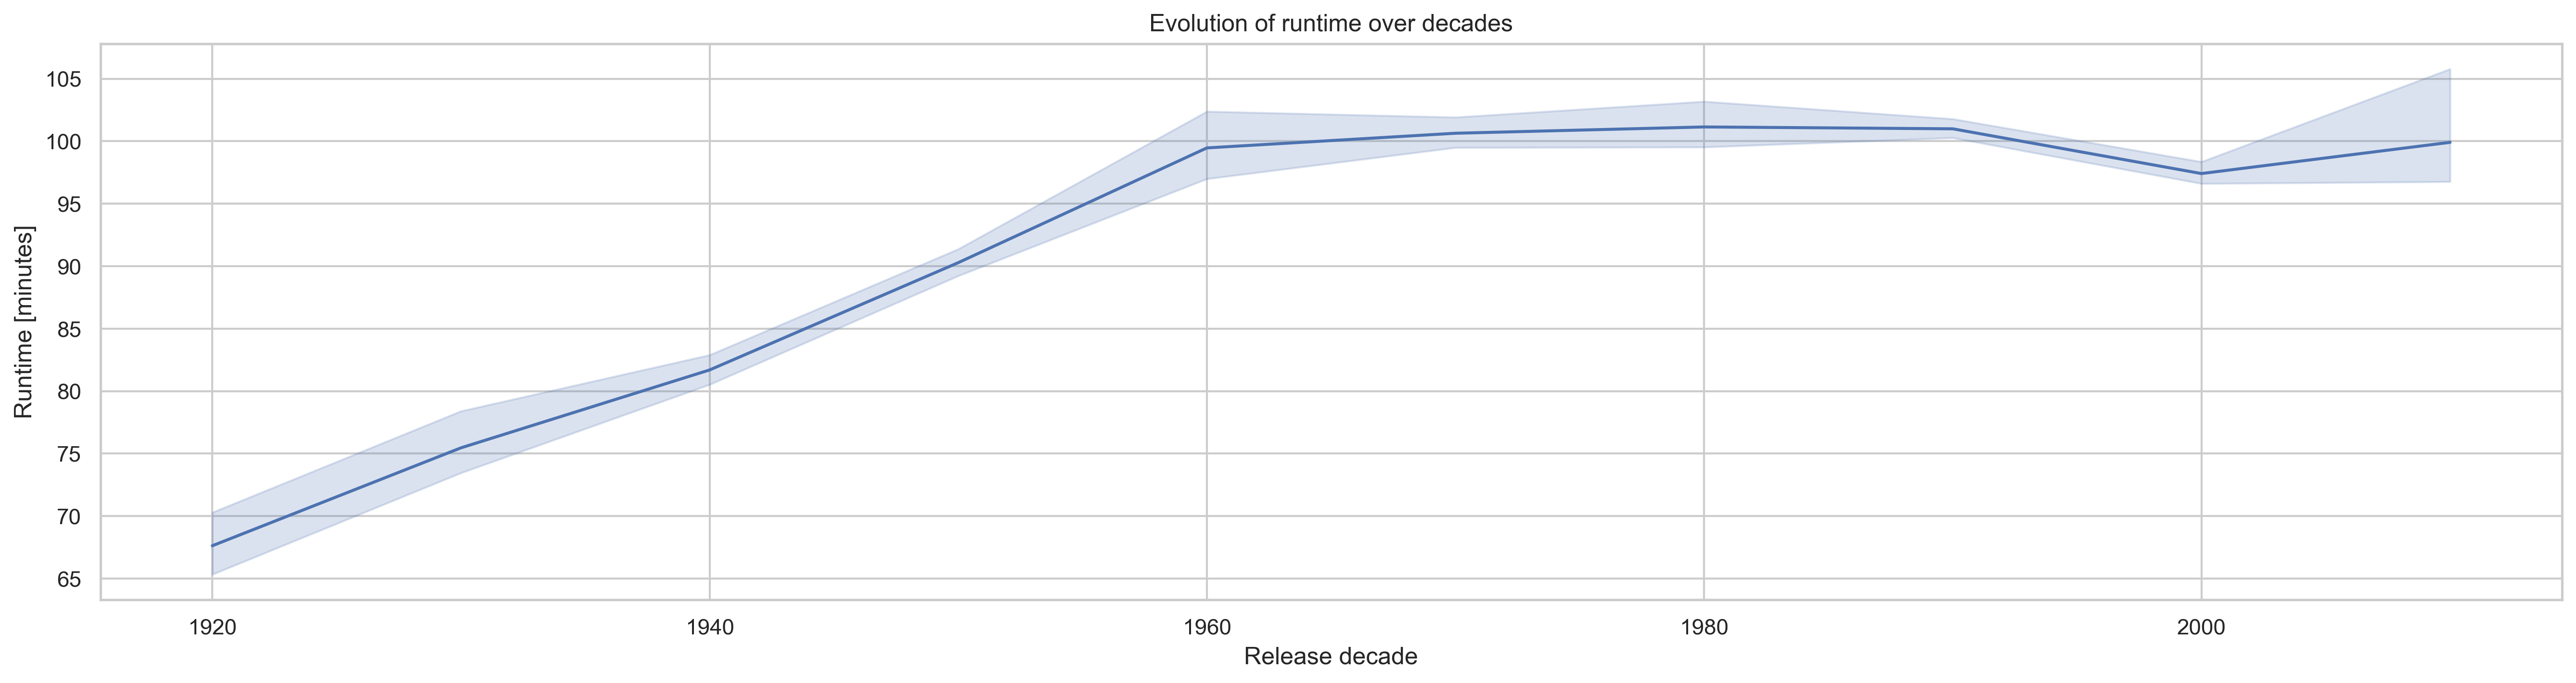

In [9]:
plt.figure(figsize=(22,5))
sns.lineplot(data=movie_runtime, x='release_decade', y='runtime', legend='brief', ci=95)
plt.xlabel('Release decade')
plt.ylabel('Runtime [minutes]')
plt.title('Evolution of runtime over decades')
plt.show()

### Genre

In [10]:
movie_genre = pd.merge(movie_df, is_of_type_df, on='movie_id').dropna(subset=['revenue', 'genre_name', 'runtime'])
genre_counts = movie_genre[['release_decade', 'genre_name']].groupby('release_decade').value_counts(normalize=False).unstack(fill_value=0)
normalized_genre_counts = genre_counts.div(genre_counts.sum(axis=1), axis=0)

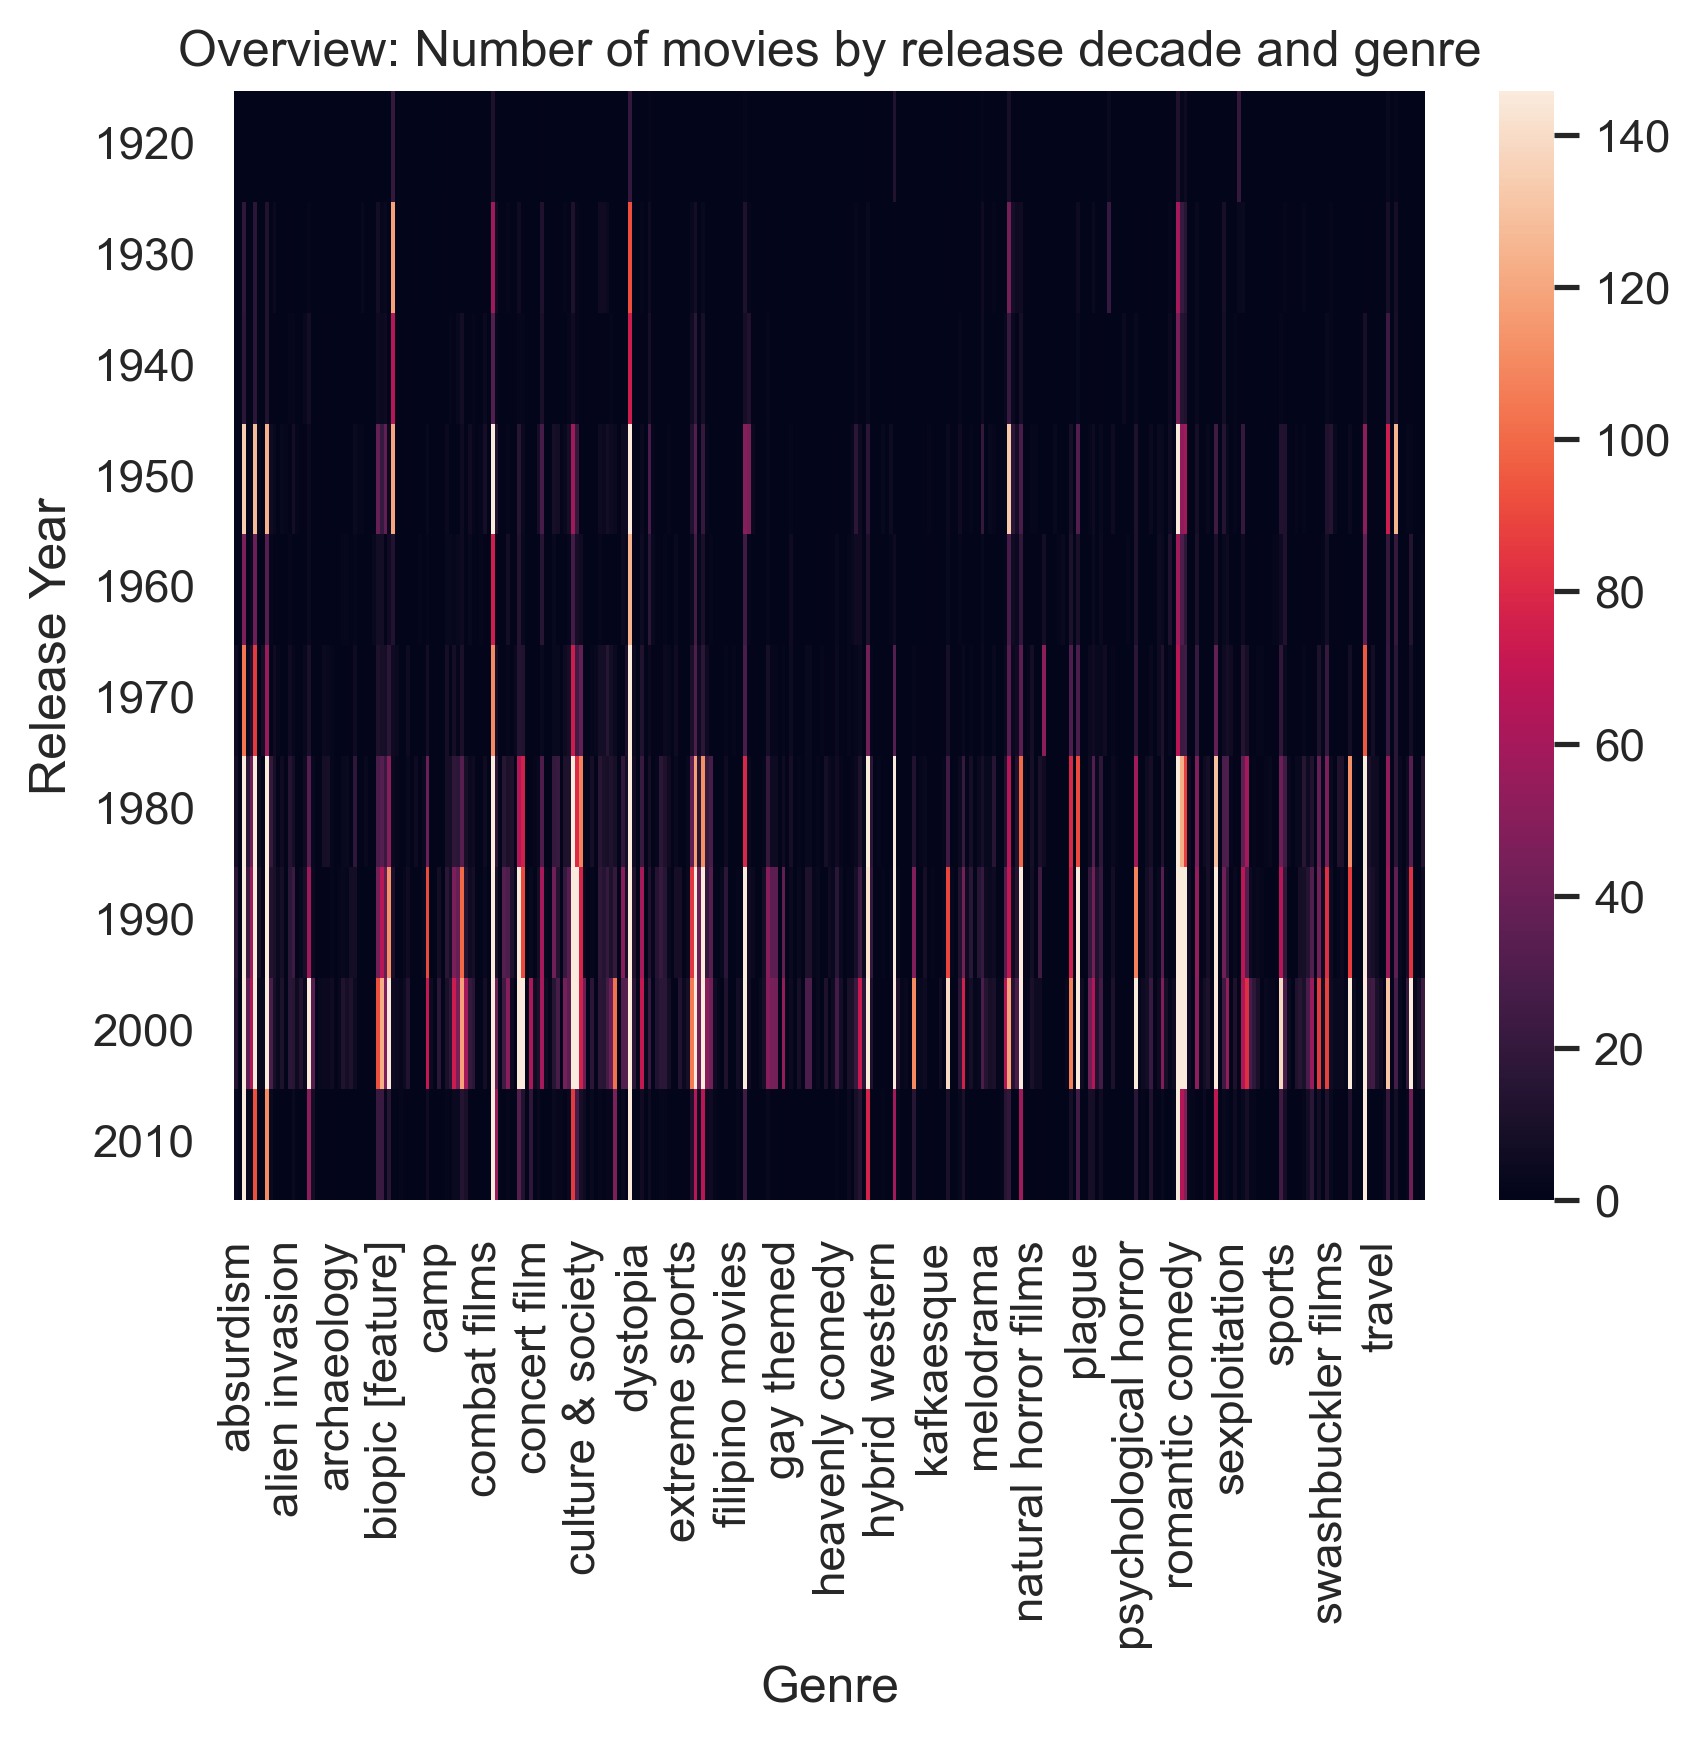

In [11]:
sns.heatmap(genre_counts, robust=True)
plt.title("Overview: Number of movies by release decade and genre")
plt.xlabel("Genre")
plt.ylabel("Release Year")
plt.tick_params(axis='y', rotation=0)
plt.show()

In [12]:
genre_revenue = movie_genre.groupby(['release_decade', 'genre_name'])['revenue'].mean().unstack(fill_value=0)

In [13]:
genre_runtime = movie_genre.groupby(['release_decade', 'genre_name'])['runtime'].mean().unstack(fill_value=0)

In [14]:
# Get the 5 most present genre and the 5 genres with the highest revenue
top_genres = np.append(genre_counts.sum(axis=0).nlargest(5).index.values, genre_revenue.mean(axis=0).nlargest(5).index.values)
top_movie_genre = movie_genre[movie_genre['genre_name'].isin(top_genres)]

Remarks:
- 'drama', 'comedy', 'romance film', 'thriller', 'action' are the most common
- 'glamorized spy film', 'alien film', "children's fantasy", 'fairy tale', 'swashbuckler films' have the highest revenues

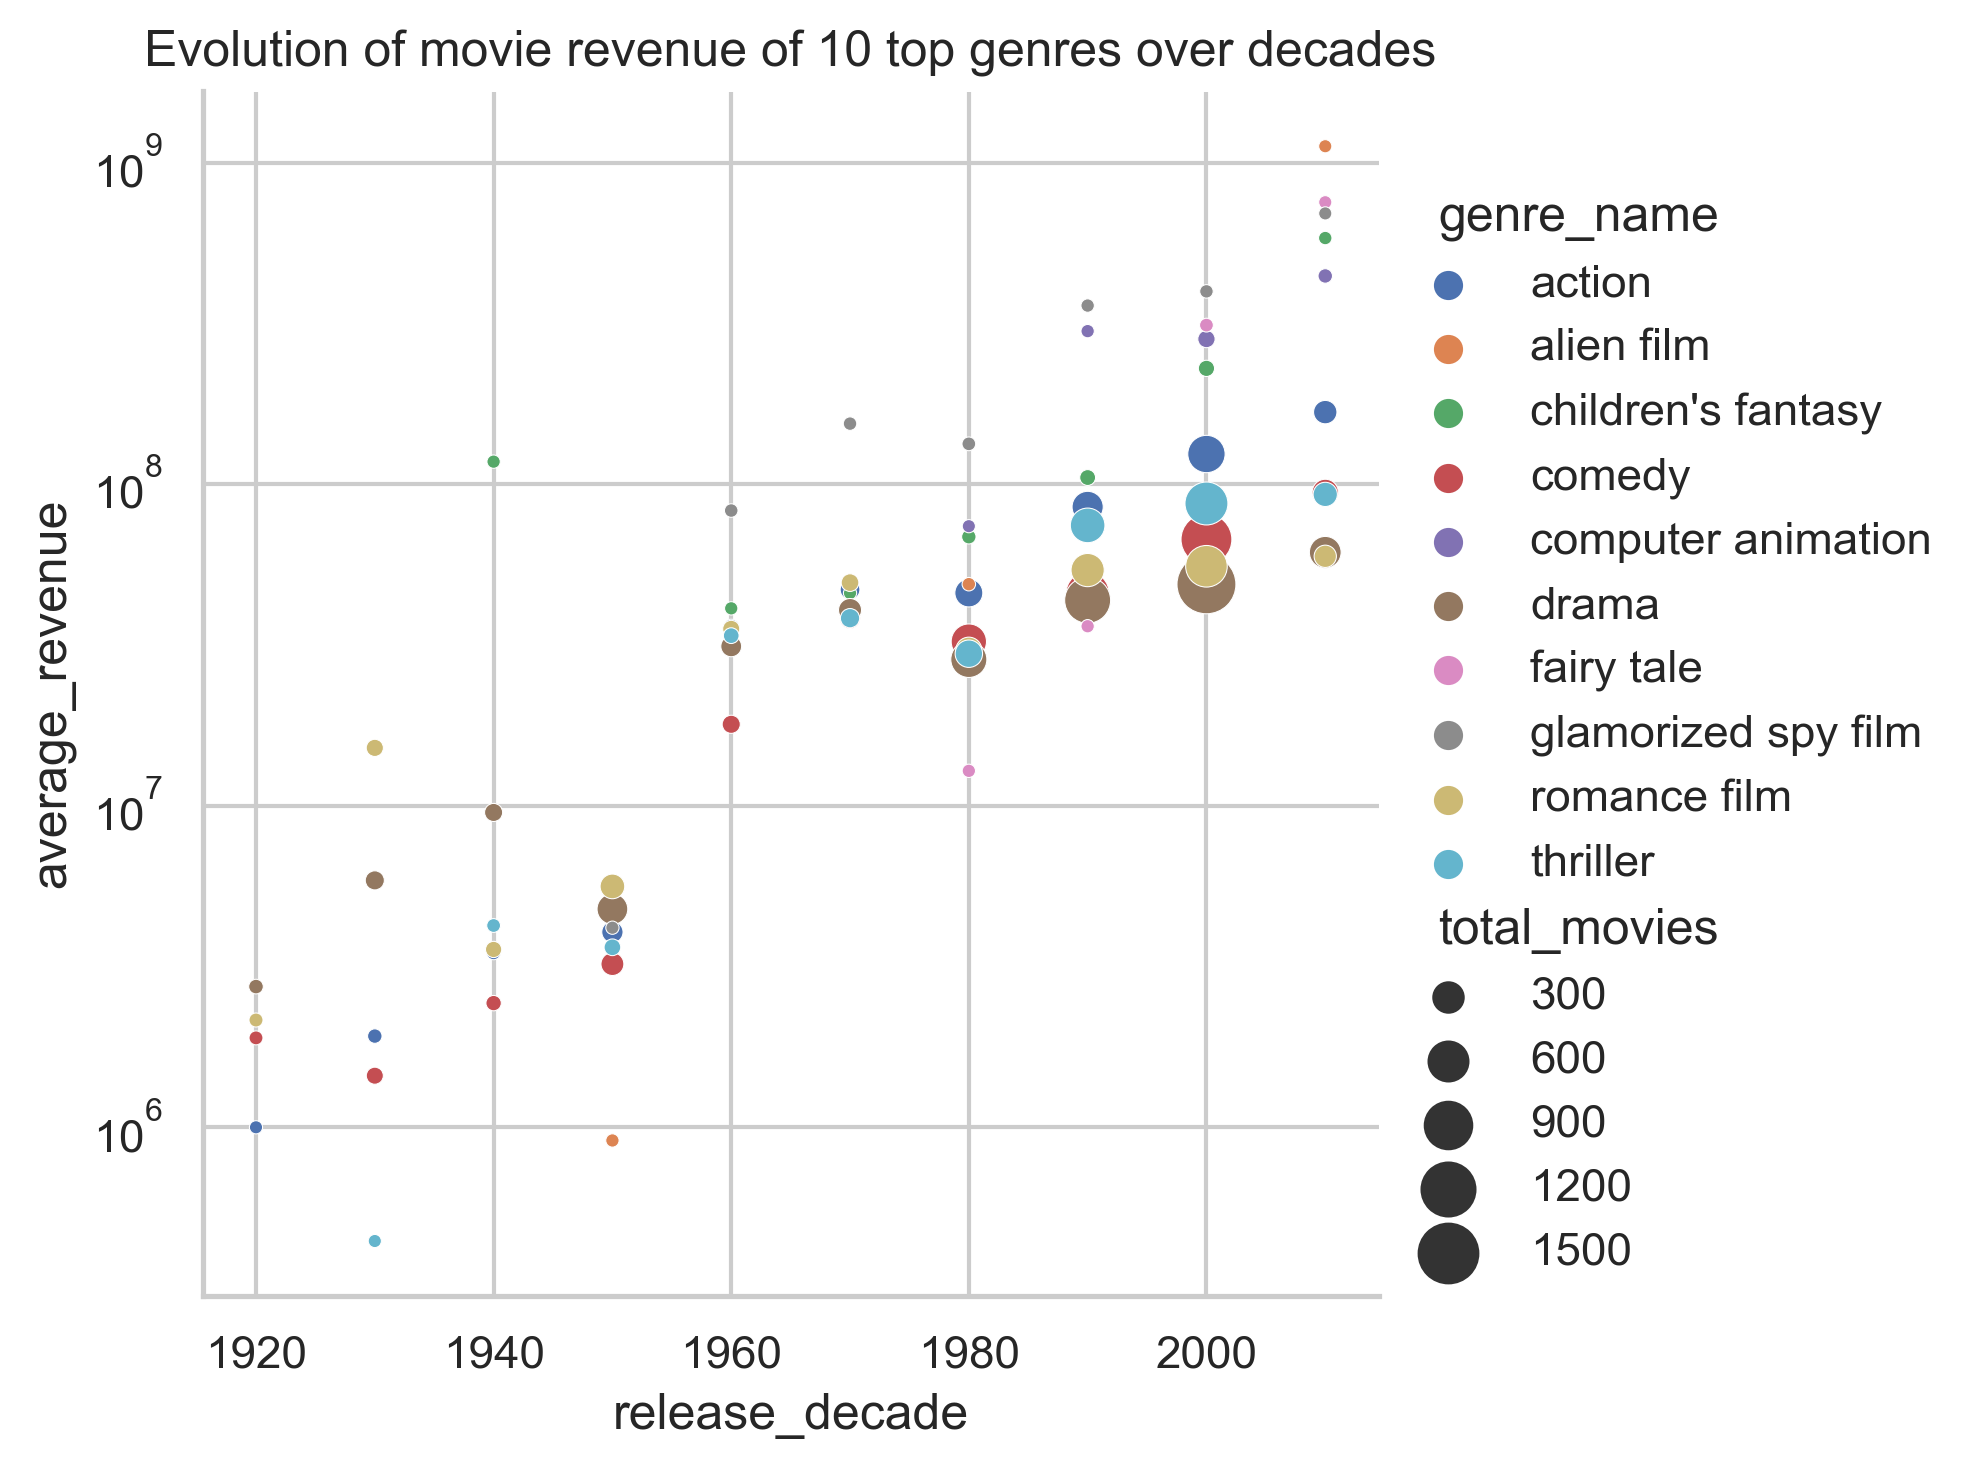

In [15]:
revenue_by_decade_and_genre = pd.DataFrame({
    'total_movies': top_movie_genre.groupby(['genre_name', 'release_decade'])['movie_id'].count(),
    'average_revenue': top_movie_genre.groupby(['genre_name', 'release_decade'])['revenue'].mean()
})

g = sns.relplot(
    data=revenue_by_decade_and_genre,
    x="release_decade", y="average_revenue",
    hue="genre_name", size="total_movies", sizes=(10, 200)
)
g.set(yscale="log")
plt.title('Evolution of movie revenue of 10 top genres over decades')
plt.show()

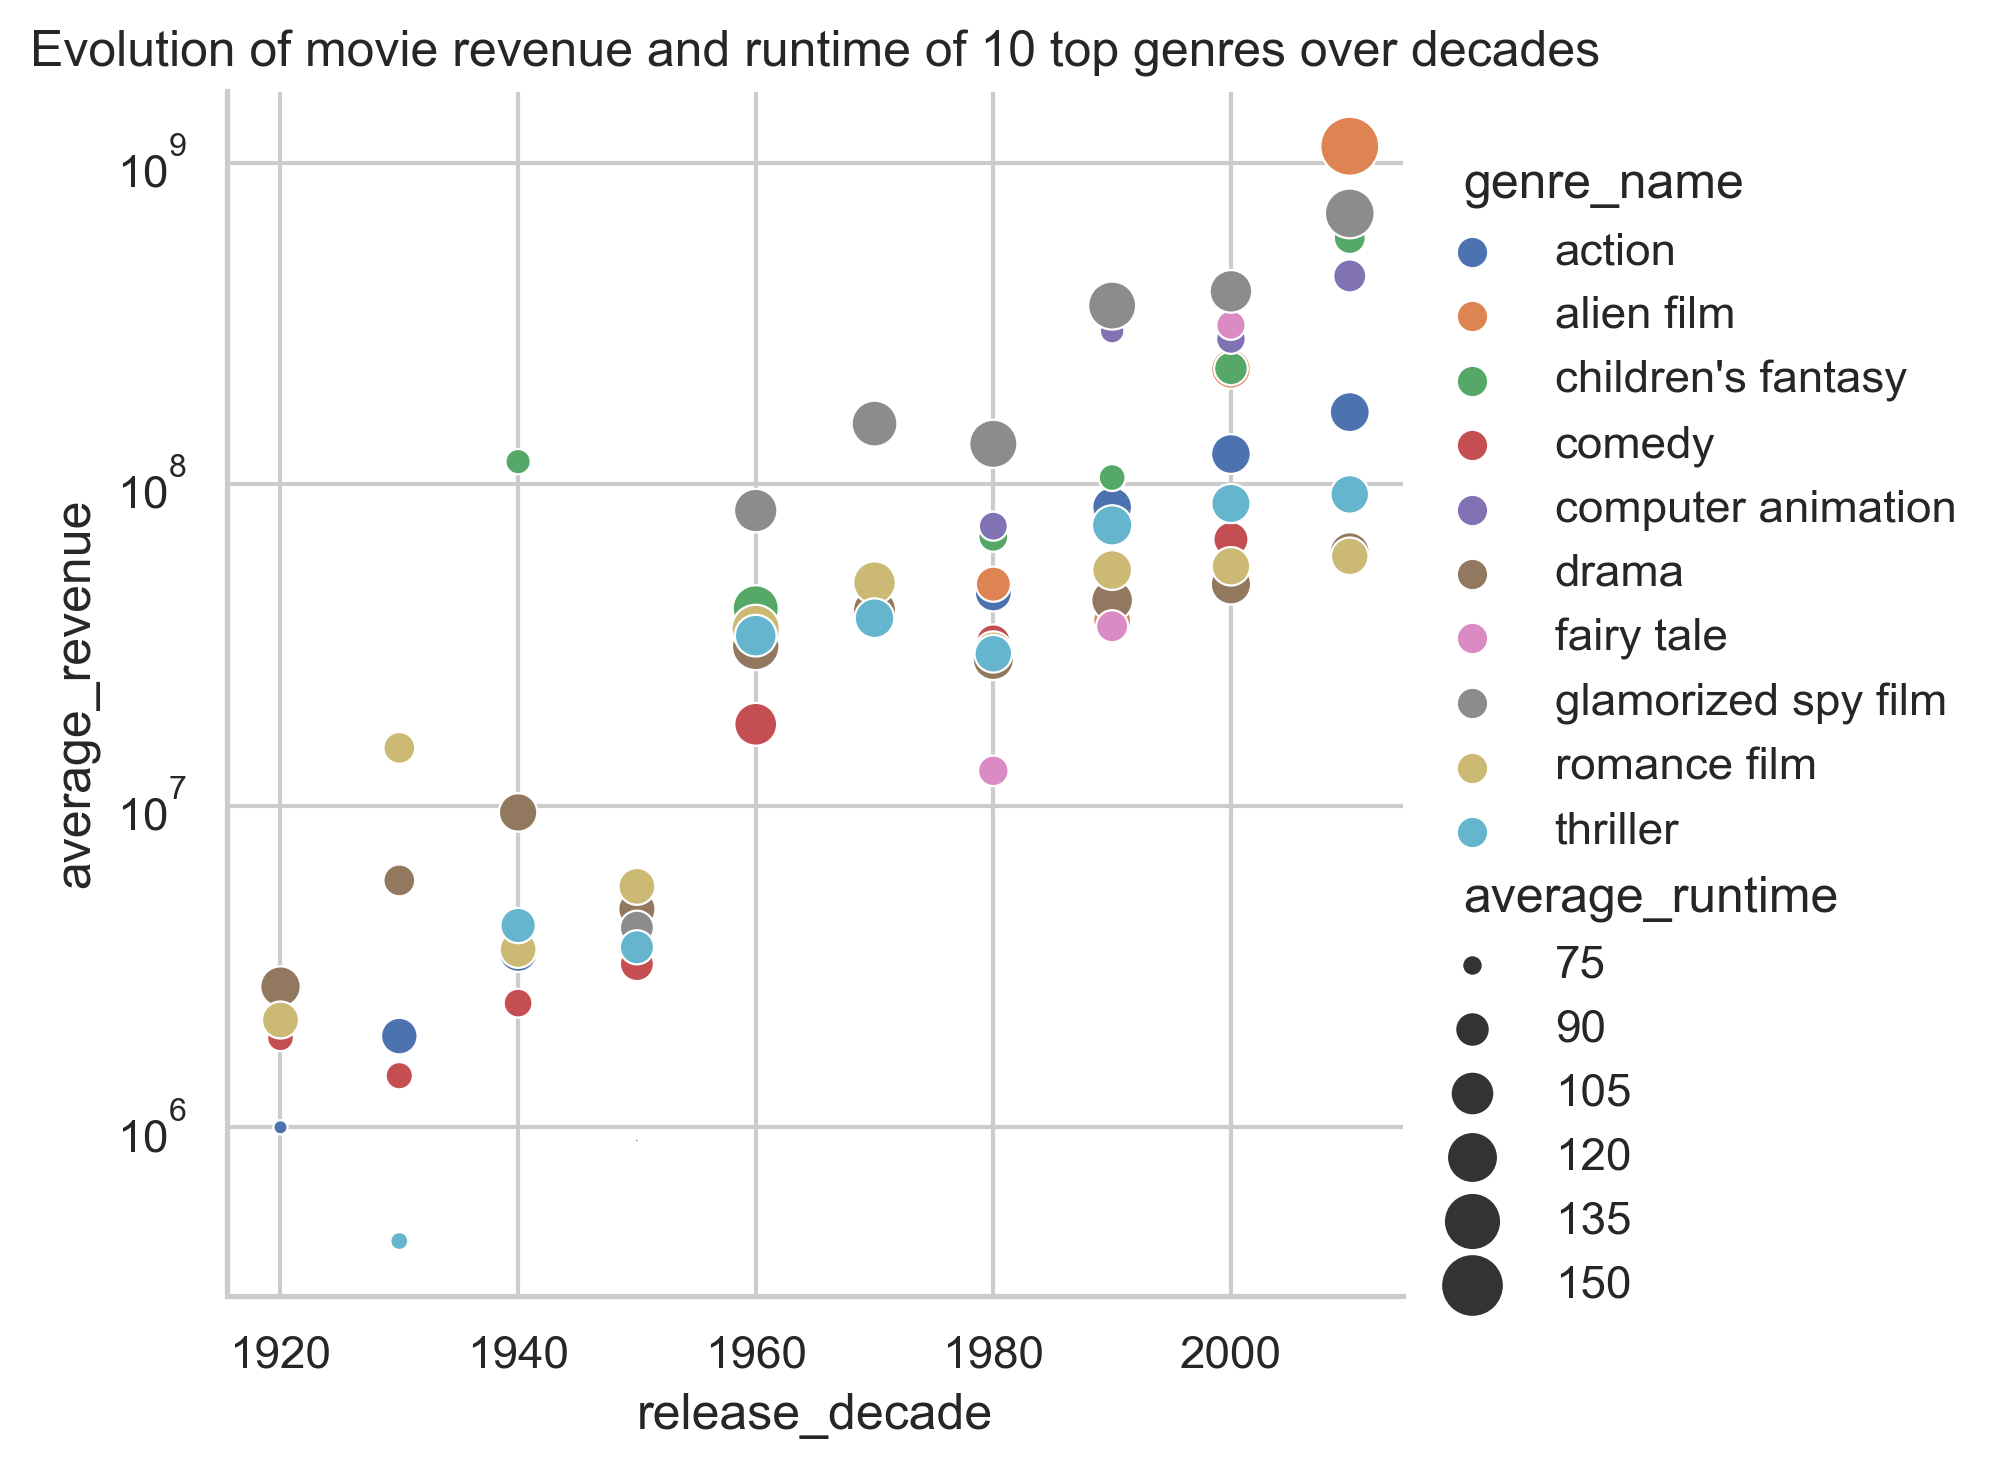

In [16]:
revenue_by_decade_genre_and_runtime = pd.DataFrame({
    'average_runtime': top_movie_genre.groupby(['genre_name', 'release_decade'])['runtime'].mean(),
    'average_revenue': top_movie_genre.groupby(['genre_name', 'release_decade'])['revenue'].mean()
})

g = sns.relplot(
    data=revenue_by_decade_genre_and_runtime,
    x="release_decade", y="average_revenue",
    hue="genre_name", size="average_runtime", sizes=(1, 200)
)
g.set(yscale="log")
plt.title('Evolution of movie revenue and runtime of 10 top genres over decades')
plt.show()

### Diversity analysis over decade through entropy measure

In [17]:
movie_country = pd.merge(movie_df, comes_from_df, on='movie_id')
movie_actor = pd.merge(pd.merge(actor_df, appears_in_df, on='actor_id'), movie_df, on='movie_id')
movie_character = pd.merge(pd.merge(character_df, belongs_to_df, on='character_id'), movie_df, on='movie_id')

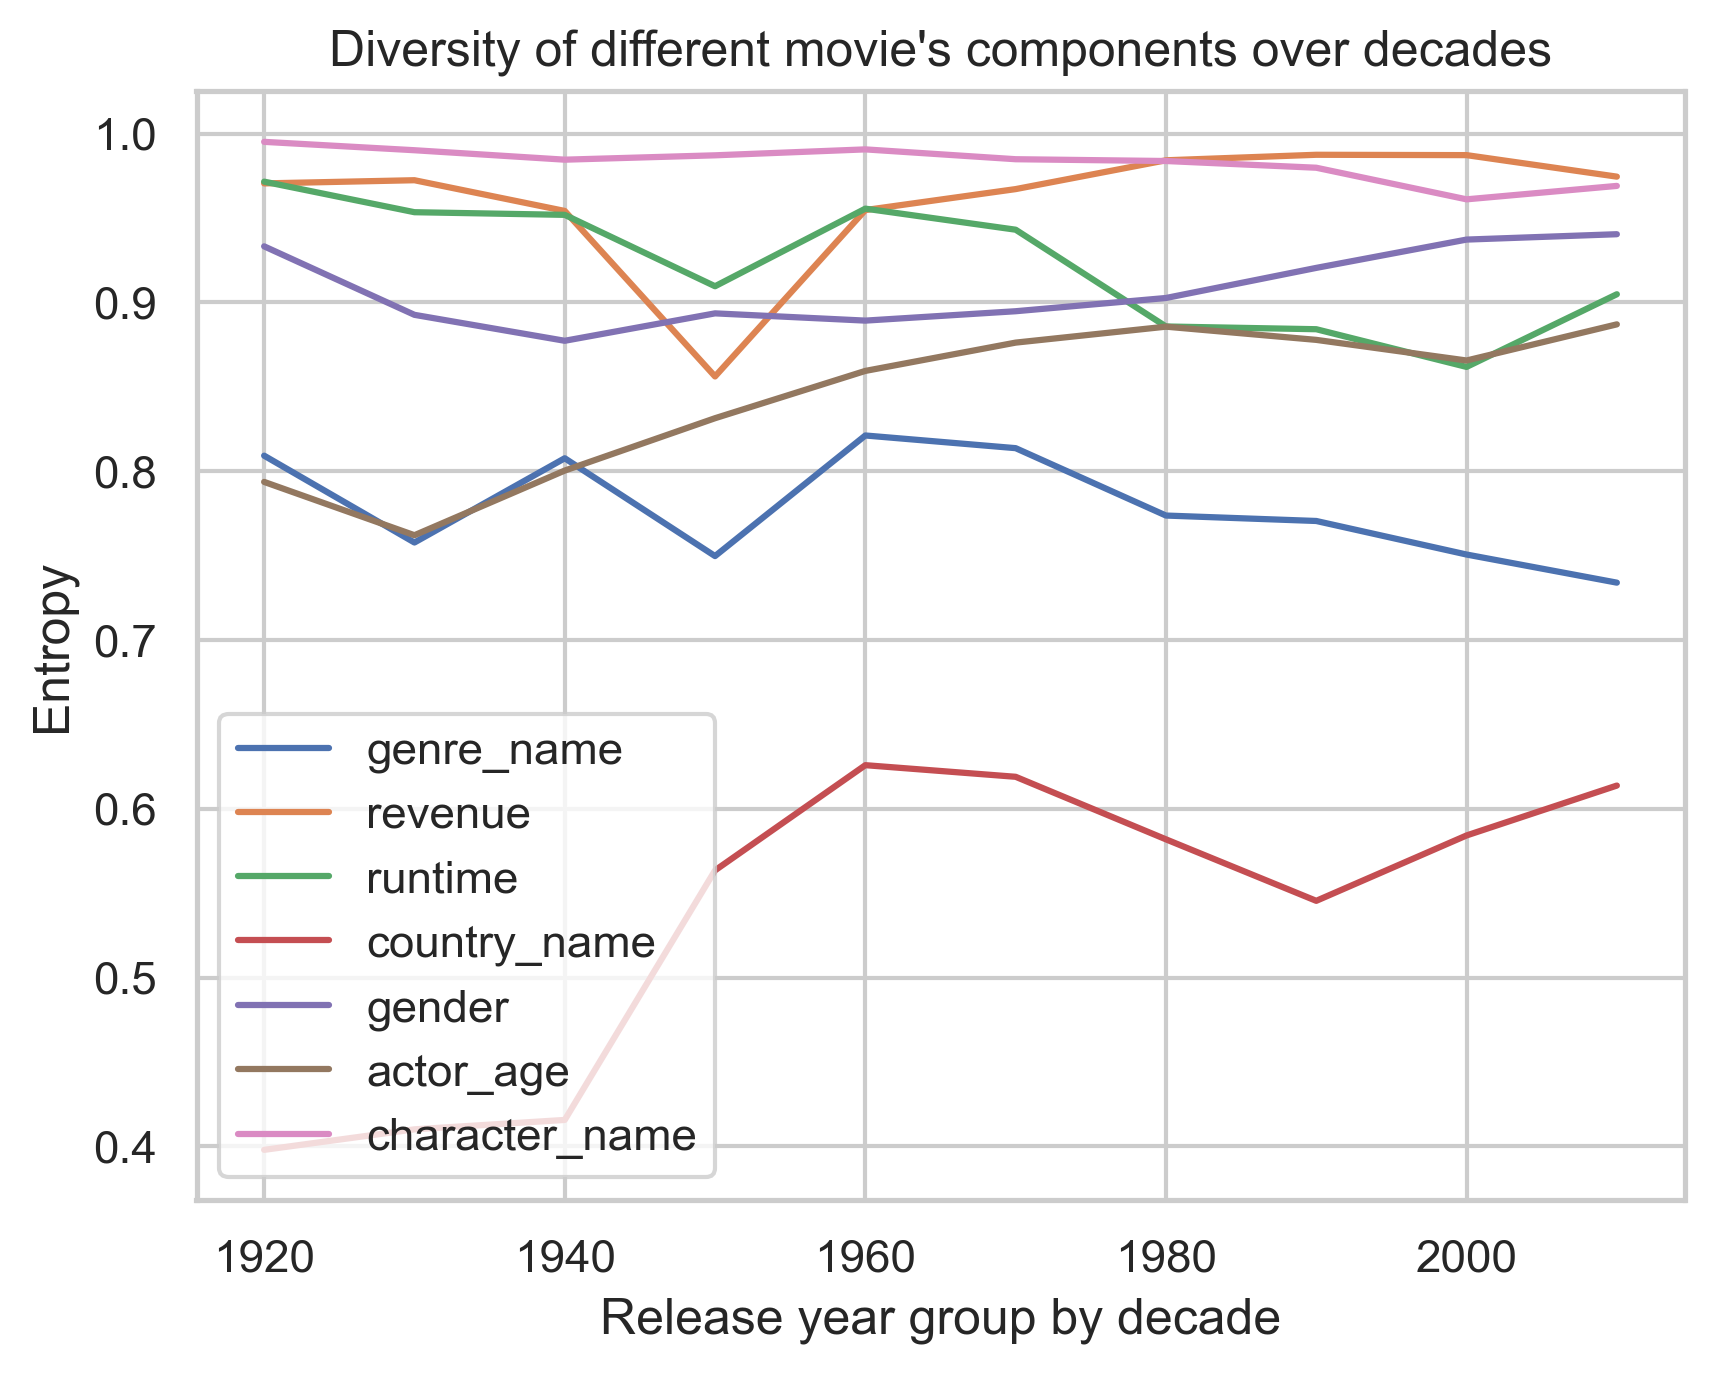

In [18]:
from scipy.stats import entropy
movie_genre.groupby('release_decade')['genre_name'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()
movie_genre.groupby('release_decade')['revenue'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()
movie_genre.groupby('release_decade')['runtime'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()

movie_country.groupby('release_decade')['country_name'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()

movie_actor.groupby('release_decade')['gender'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()
movie_actor.groupby('release_decade')['actor_age'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()

movie_character.groupby('release_decade')['character_name'].apply(lambda x : entropy(x.value_counts(), base=2)/np.log2(x.nunique())).plot()

plt.title("Diversity of different movie's components over decades")
plt.xlabel("Release year group by decade")
plt.ylabel("Entropy")
plt.legend()
plt.show()

### Country

In [19]:
top_countries = movie_country['country_name'].value_counts().nlargest(10).index

In [20]:
top_movie_country = movie_country[movie_country['country_name'].isin(top_countries)]

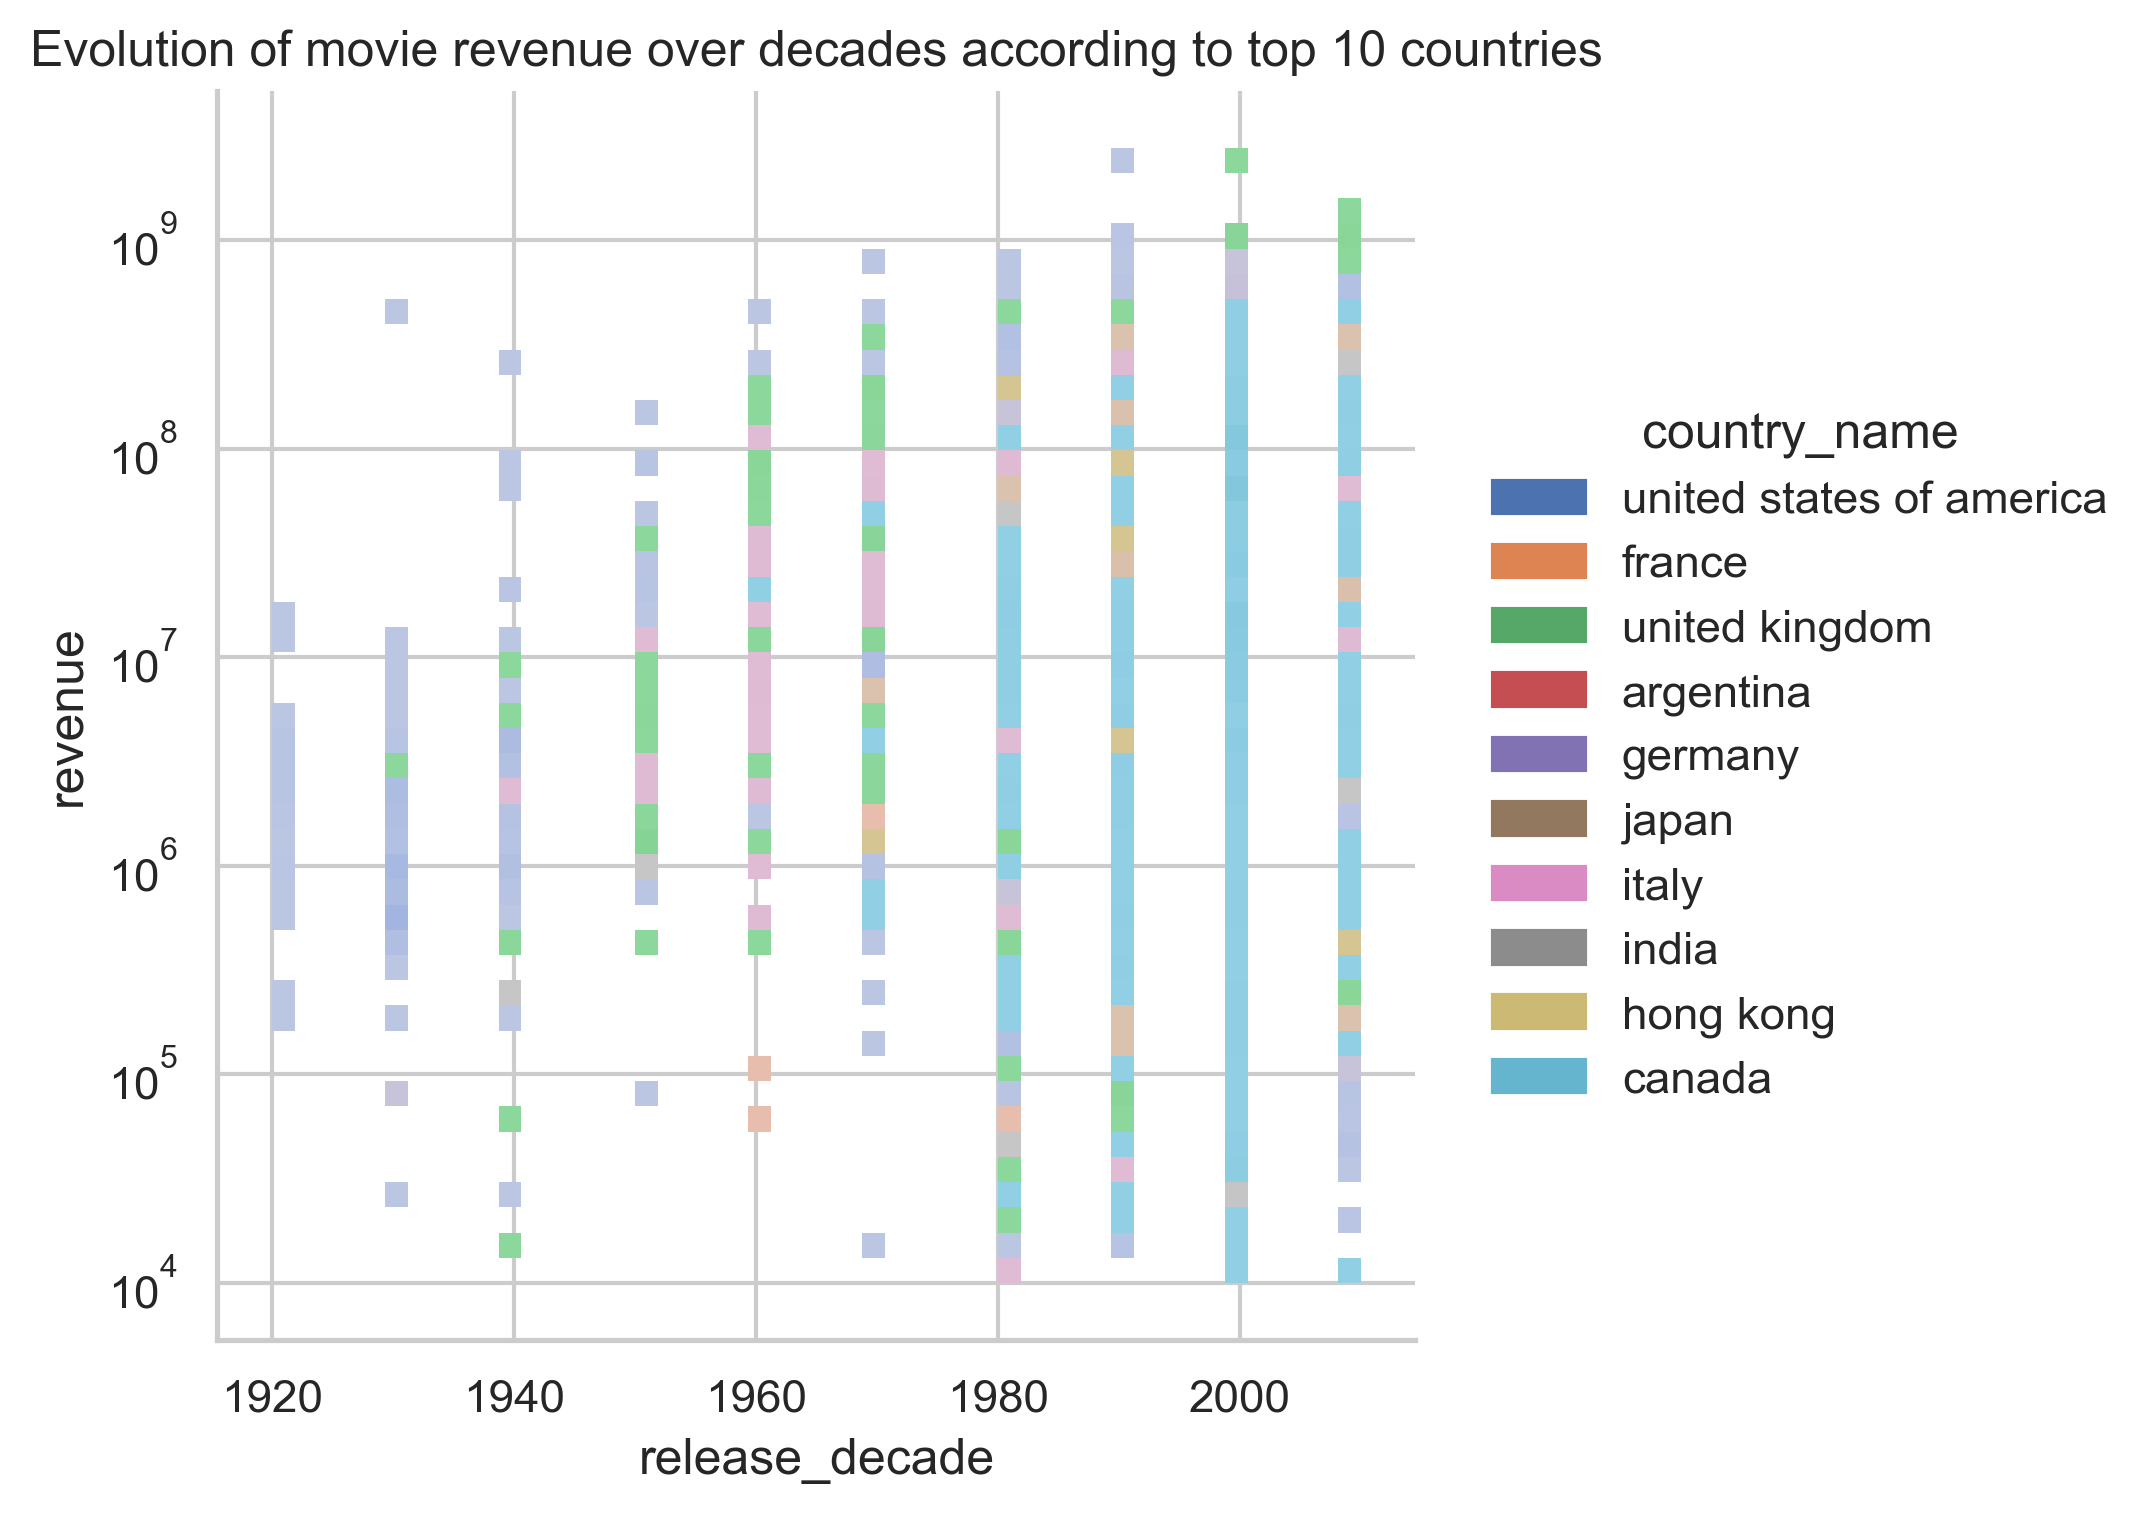

In [21]:
sns.displot(data=top_movie_country, x="release_decade", y="revenue", hue="country_name", log_scale=(False, True))
plt.title('Evolution of movie revenue over decades according to top 10 countries')
plt.show()

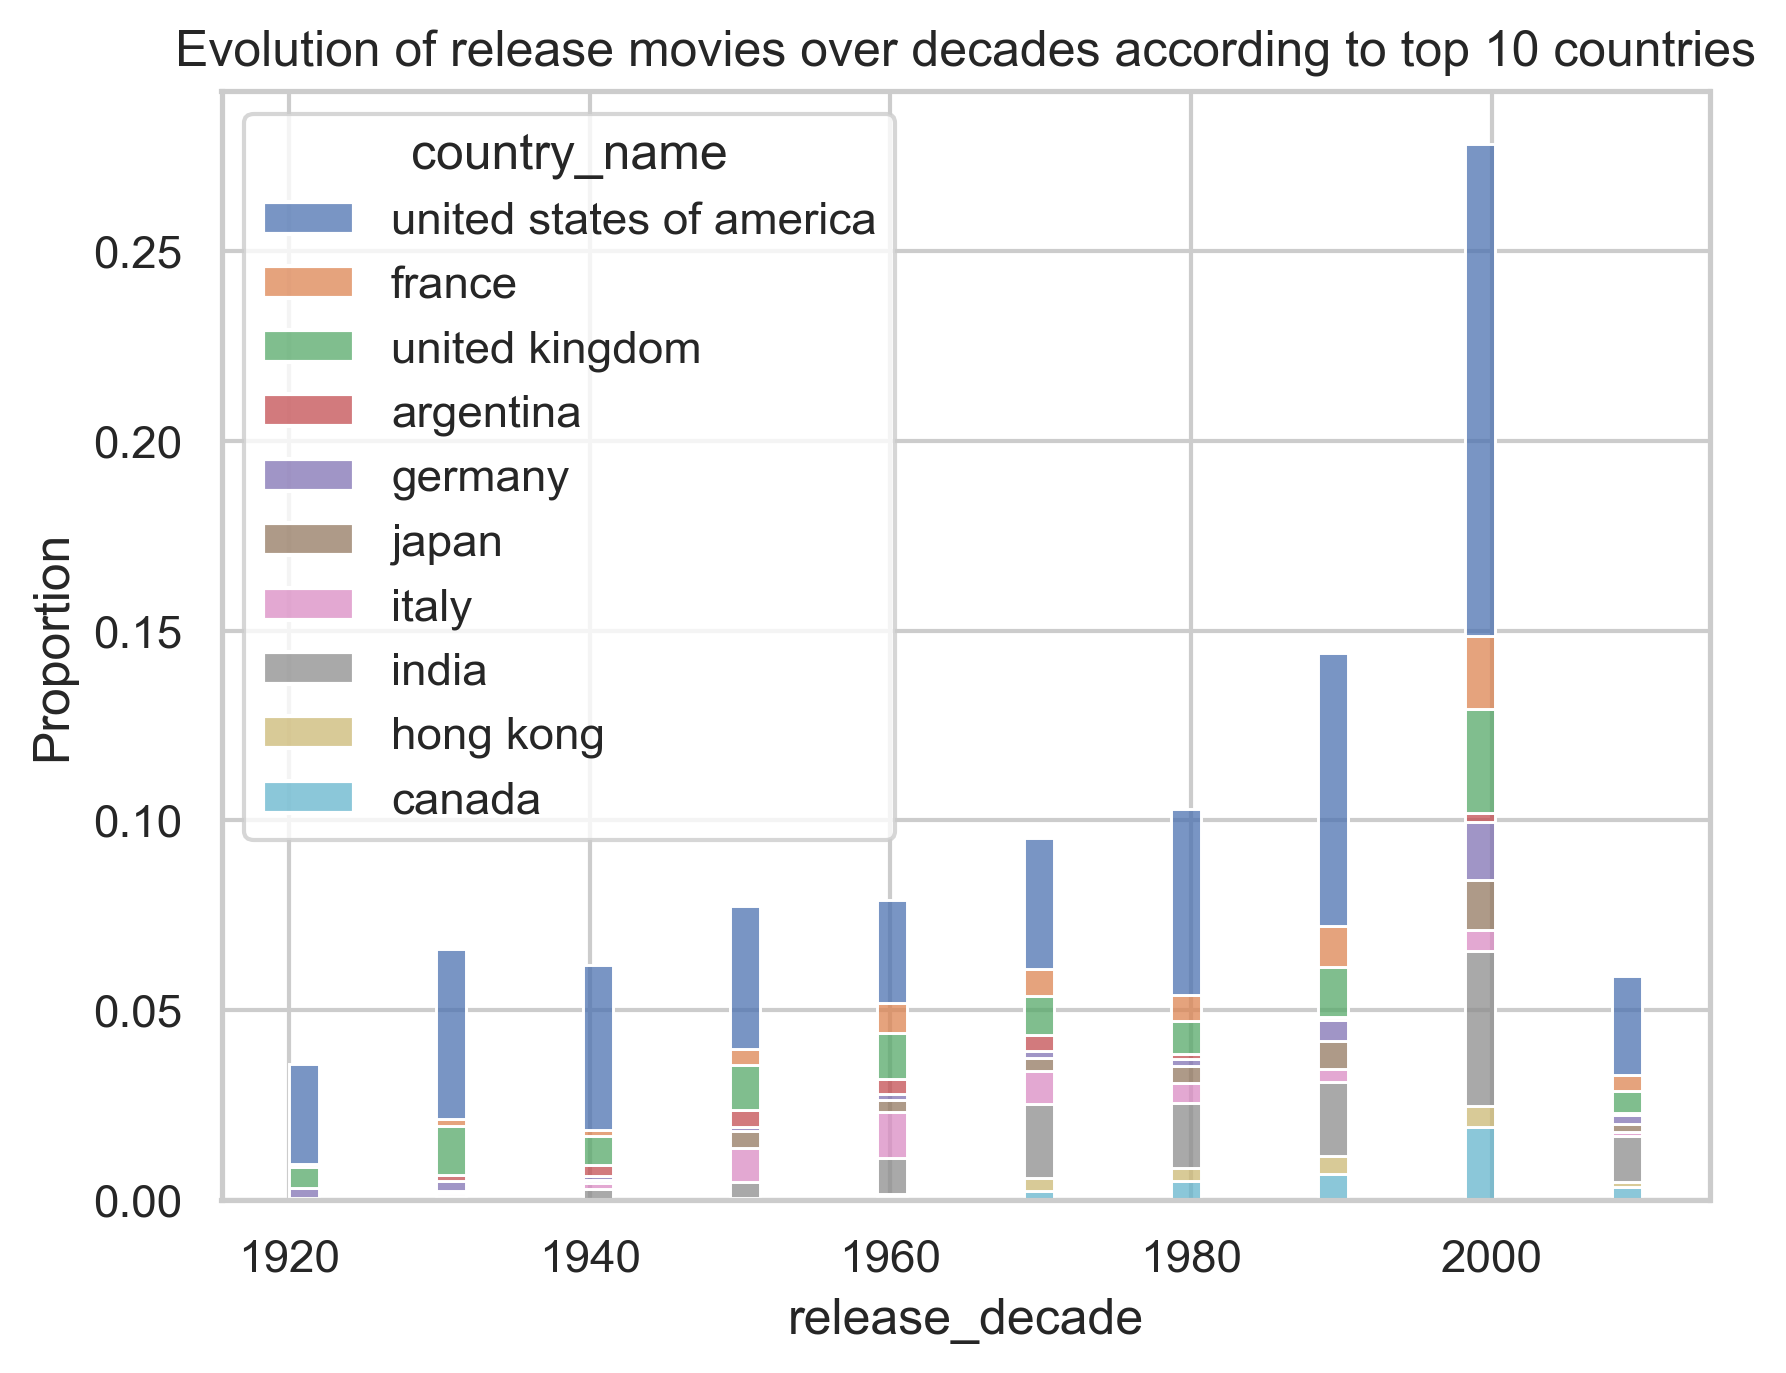

In [22]:
sns.histplot(data=top_movie_country, x='release_decade', hue='country_name', multiple='stack', stat='proportion')
plt.title('Evolution of release movies over decades according to top 10 countries')
plt.show()

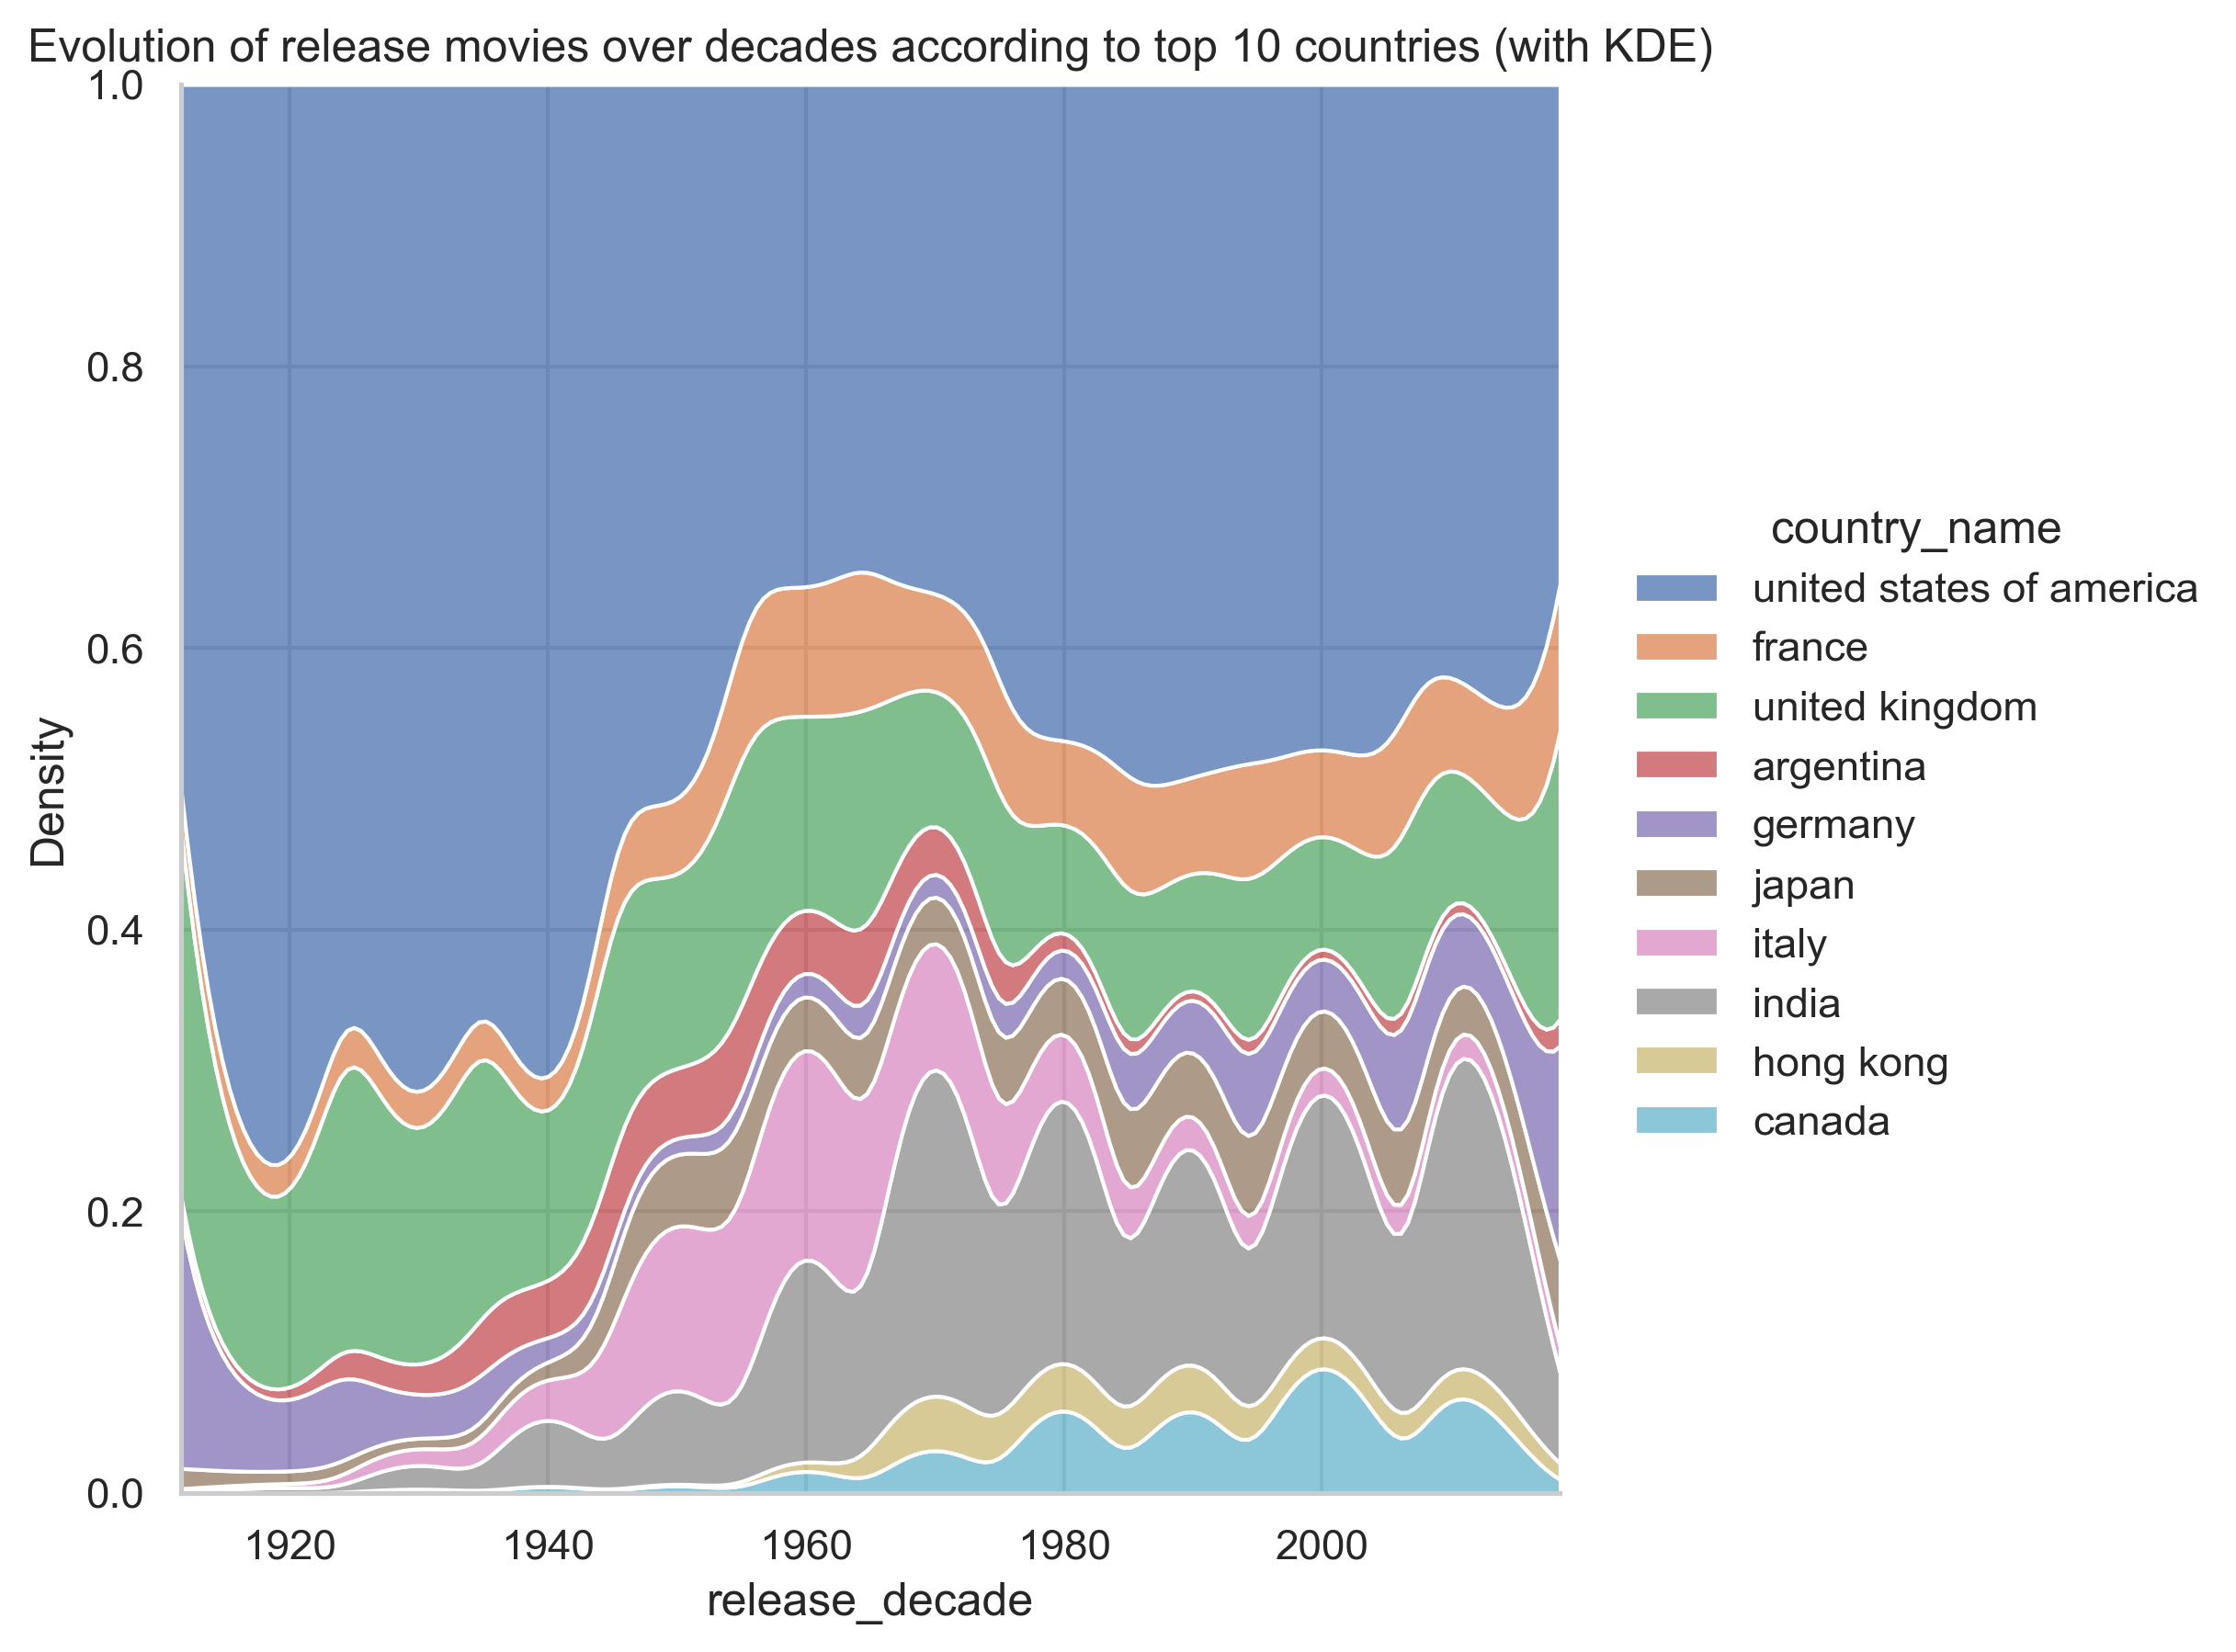

In [23]:
sns.displot(
    data=movie_country[movie_country['country_name'].isin(top_countries)],
    x="release_decade", hue="country_name",
    kind="kde", height=6,
    multiple="fill", clip=(0, None)
)
plt.title('Evolution of release movies over decades according to top 10 countries (with KDE)')
plt.show()